##  Sentiment Analysis for Movie Dataset


In [1]:
import pandas as pd
 
import matplotlib.pyplot as plt
import numpy as np
import glob
from bs4 import BeautifulSoup
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, confusion_matrix,classification_report

from joblib import dump, load


from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santoshkhatiwada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
trainPos = glob.glob('../data/aclImdb/train/pos/*.txt')
trainNeg = glob.glob('../data/aclImdb/train/neg/*.txt')
print("total reviews for training : {}".format(len(trainPos)+len(trainNeg)))
testPos = glob.glob('../data/aclImdb/test/pos/*.txt')
testNeg = glob.glob('../data/aclImdb/test/neg/*.txt')
print("total reviews for testing : {}".format(len(testPos)+len(testNeg)))

total reviews for training : 25000
total reviews for testing : 25000


**Let's convert the text files into dataframe for further processing.**

In [3]:
def extractText(folder):
    allText = []
    textFiles = []
    for fileName in folder:
        with open(fileName,'r') as txtfile:
            text = txtfile.read()
            text = text.lower()
            cleanText = BeautifulSoup(text,"html.parser").text
            allText.append(cleanText)
            textFiles.append(fileName)
    return allText, textFiles

In [4]:
trainPosText,trainPosFiles = extractText(trainPos)
trainNegText,trainNegFiles = extractText(trainNeg)
testPosText,testPosFiles = extractText(testPos)
testNegText,testNegFiles = extractText(testNeg)

#for positive training files
dfTrainPos = pd.DataFrame(trainPosText,columns=['reviews'])
dfTrainPos['filename'] = trainPosFiles

#for negative training files
dfTrainNeg = pd.DataFrame(trainNegText,columns=['reviews'])
dfTrainNeg['filename'] = trainNegFiles

#for positive testing files
dfTestPos = pd.DataFrame(testPosText,columns=['reviews'])
dfTestPos['filename'] = testPosFiles

#for negative testing files
dfTestNeg = pd.DataFrame(testNegText,columns=['reviews'])
dfTestNeg['filename'] = testNegFiles


In [5]:
dfTrainPos.head(5)

,reviews,filename
0,bromwell high is a cartoon comedy. it ran at t...,../data/aclImdb/train/pos/0_9.txt
1,homelessness (or houselessness as george carli...,../data/aclImdb/train/pos/10000_8.txt
2,brilliant over-acting by lesley ann warren. be...,../data/aclImdb/train/pos/10001_10.txt
3,this is easily the most underrated film inn th...,../data/aclImdb/train/pos/10002_7.txt
4,this is not the typical mel brooks film. it wa...,../data/aclImdb/train/pos/10003_8.txt


In [6]:
dfTrainNeg.head(5)

,reviews,filename
0,story of a man who has unnatural feelings for ...,../data/aclImdb/train/neg/0_3.txt
1,airport '77 starts as a brand new luxury 747 p...,../data/aclImdb/train/neg/10000_4.txt
2,this film lacked something i couldn't put my f...,../data/aclImdb/train/neg/10001_4.txt
3,"sorry everyone,,, i know this is supposed to b...",../data/aclImdb/train/neg/10002_1.txt
4,when i was little my parents took me along to ...,../data/aclImdb/train/neg/10003_1.txt


In [7]:
dfTestPos.head(5)

,reviews,filename
0,i went and saw this movie last night after bei...,../data/aclImdb/test/pos/0_10.txt
1,actor turned director bill paxton follows up h...,../data/aclImdb/test/pos/10000_7.txt
2,as a recreational golfer with some knowledge o...,../data/aclImdb/test/pos/10001_9.txt
3,"i saw this film in a sneak preview, and it is ...",../data/aclImdb/test/pos/10002_8.txt
4,bill paxton has taken the true story of the 19...,../data/aclImdb/test/pos/10003_8.txt


In [8]:
dfTestNeg.head(5)

,reviews,filename
0,once again mr. costner has dragged out a movie...,../data/aclImdb/test/neg/0_2.txt
1,this is an example of why the majority of acti...,../data/aclImdb/test/neg/10000_4.txt
2,"first of all i hate those moronic rappers, who...",../data/aclImdb/test/neg/10001_1.txt
3,not even the beatles could write songs everyon...,../data/aclImdb/test/neg/10002_3.txt
4,brass pictures (movies is not a fitting word f...,../data/aclImdb/test/neg/10003_3.txt


**let's build the wordcloud of the training data set initially for observing the frequency of words as well as their importance.**

In [9]:
stpwords = list(STOPWORDS)
stpwords.extend(stopwords.words('english'))
stpwords.extend(['movie','movies','film','films',
                 'actor','actress','cinema',
                 'story','br','role','dramas','drama',
                 'characters','character','director'])
stpwords = set(stpwords)


In [10]:
def wordCloud(text):
    wordcloud = WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).generate(text)
    return wordcloud

In [11]:
def plotWordCloud(wordcloud):
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [12]:
wordTrainPos = " ".join(review.strip() for review in dfTrainPos.reviews)
wordTrainNeg = " ".join(review.strip() for review in dfTrainNeg.reviews)

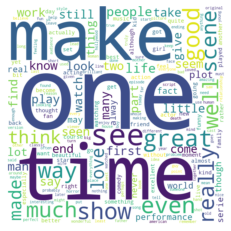

In [13]:
wordcloudPos = wordCloud(wordTrainPos)
plotWordCloud(wordcloudPos)

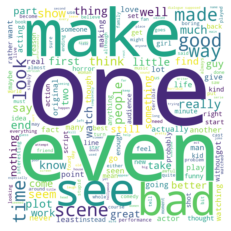

In [14]:
wordcloudNeg = wordCloud(wordTrainNeg)
plotWordCloud(wordcloudNeg)

In [15]:
wordcloudPos.to_file('../reports/wordcloud/wordcloudpos.png')

In [16]:
wordcloudNeg.to_file('../reports/wordcloud/wordcloudNeg.png')

**The wordcloud shown here shows the most common words that appear in the texts. However, the words shown here clearly donot define the sentiments of positive or negative reviews.**

**Let's see the weights of the words given by count vectorizer and visualize it.**

In [17]:
stop_words = stopwords.words('english')
cntVectorizerPos = CountVectorizer(binary=False, stop_words=list(stpwords), min_df=5, max_df=0.90,max_features=40000)
cntVectorizerNeg = CountVectorizer(binary=False, stop_words=list(stpwords), min_df=5, max_df=0.90,max_features=40000)
dataTrainPos = cntVectorizerPos.fit_transform(dfTrainPos['reviews'])
dataTrainNeg = cntVectorizerNeg.fit_transform(dfTrainNeg['reviews'])

/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
featureNamesPos=cntVectorizerPos.get_feature_names()
featureNamesNeg=cntVectorizerNeg.get_feature_names()

In [19]:
def getTopFeatures(features,n,featuresName):
    dictionary = {}
    featuresSum = features.sum(axis=0)[0,:]
    featuresSum = np.squeeze(np.asarray(featuresSum))
    sortedIndices = np.argsort(-1*featuresSum)[0:n]
    for index in sortedIndices:
        dictionary[featuresName[index]]=featuresSum[index]
    return dictionary

In [20]:
dictionaryPos = getTopFeatures(dataTrainPos,500,featureNamesPos)
dictionaryNeg = getTopFeatures(dataTrainNeg,500,featureNamesNeg)
  

In [21]:
def wordCloudFromFrequency(dictionary):
    return WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).\
                                                generate_from_frequencies(dictionary)

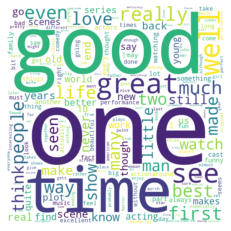

In [22]:
wordcloudPos = wordCloudFromFrequency(dictionaryPos)
plotWordCloud(wordcloudPos)


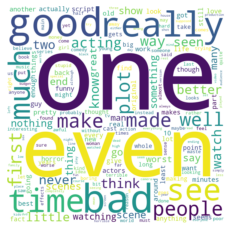

In [23]:
wordcloudNeg = wordCloudFromFrequency(dictionaryNeg)
plotWordCloud(wordcloudNeg)

In [24]:
wordcloudPos.to_file('../reports/wordcloud/wordcloudPoscount.png')
wordcloudNeg.to_file('../reports/wordcloud/wordcloudNegcount.png')

**As seen from the wordcloud above, we observe top 500 most repetitive words and they too may not represent the words that are important in classifying the sentiments.**

**let's use some of the classical approaches through which we can know the type of words that are used in classifying sentiments. let's update the label by our own. The positive sentiments are given label 1 and negative sentiments are given label 0.**

## Random Forest for Visualization

In [25]:
dfTrainPos['label'] = 1
dfTrainNeg['label'] = 0
dfTestPos['label'] = 1
dfTestNeg['label'] = 0
trainDf = dfTrainPos.append(dfTrainNeg,ignore_index=True)
trainDf = trainDf.sample(frac=1)#shuffle the dataframe to randomize

testDf = dfTestPos.append(dfTestNeg,ignore_index=True)
testDf = testDf.sample(frac=1)
trainDf.head(5)

,reviews,filename,label
10911,"arguably this is a very good ""sequel"", better ...",../data/aclImdb/train/pos/8571_7.txt,1
7815,whilst reading through the comments left for t...,../data/aclImdb/train/pos/5785_10.txt,1
10080,"an overlong, but compelling retelling of the f...",../data/aclImdb/train/pos/7823_7.txt,1
2344,"and my children love it now! granted, i can wa...",../data/aclImdb/train/pos/1210_8.txt,1
22110,this has to be the worst piece of garbage i've...,../data/aclImdb/train/neg/73_1.txt,0


**We are considering the words that are present in at least 5 documents and rejecting the words that are present in 95% of the text files.**

In [26]:
countVect = CountVectorizer(binary=False, stop_words=stop_words,
                             token_pattern="[a-zA-Z]{2,}",#only considering words which have 2 alphabets in minimum
                             min_df=5,max_df=0.95)
trainFeatures = countVect.fit_transform(trainDf.reviews)
features = countVect.get_feature_names()

In [27]:
print("the number of words taken for training sentiments: {}".format(len(features)))


the number of words taken for training sentiments: 26817


**lets choose the best hyperparameters.**

In [30]:
params = {
    'max_depth':[5,6,7],
    'max_features':[0.9, 1.0],
    'n_estimators':[10,15]
}

rfClassifier = RandomForestClassifier(random_state=6,n_jobs=-1)
gridSearch = GridSearchCV(rfClassifier, params,verbose=3,n_jobs=-1)
gridSearch.fit(trainFeatures, trainDf.label)
print(gridSearch.best_estimator_)

/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


**For the given range of parameters, the best hyperparameters are given and best estimator is obtained.**

the accuracy score for training set : 0.73276
the accuracy score for testing set : 0.72488
[[ 7498  5002]
 [ 1876 10624]]
              precision    recall  f1-score   support

           0       0.80      0.60      0.69     12500
           1       0.68      0.85      0.76     12500

    accuracy                           0.72     25000
   macro avg       0.74      0.72      0.72     25000
weighted avg       0.74      0.72      0.72     25000



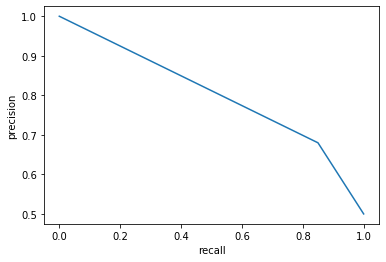

In [28]:
bestClassifier = gridSearch.best_estimator_
dump(bestClassifier, '../models/rfClassifier.joblib')

loadedModel = load('../models/rfClassifier.joblib')
rfTrainPredict = loadedModel.predict(trainFeatures)
score = accuracy_score(trainDf.label, rfTrainPredict)
print("the accuracy score for training set : {}".format(score))

# for testing data
testFeatures = countVect.transform(testDf.reviews)
rfTestPredict = loadedModel.predict(testFeatures)
score = accuracy_score(testDf.label, rfTestPredict)
print("the accuracy score for testing set : {}".format(score))
print(confusion_matrix(testDf.label,rfTestPredict))
print(classification_report(testDf.label,rfTestPredict))
precision, recall, threshold = precision_recall_curve(testDf.label,rfTestPredict)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [32]:
featureImp = loadedModel.feature_importances_
indices = np.argsort(-featureImp)

trainWords = {}
for index in indices[0:100]:
    trainWords[features[index]] = featureImp[index]


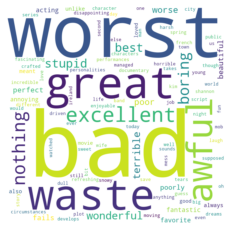

In [33]:
wordcloudAfterClassifier = wordCloudFromFrequency(trainWords)
plotWordCloud(wordcloudAfterClassifier)

In [34]:
wordcloudAfterClassifier.to_file('../reports/wordcloud/wordcloudafterclassifier.png')

**The wordcloud above shows that after training, we have obtained the most important top 100 words that are used for classification. The words are mostly the adjective describing the positive and negative sentiments.**

In [36]:
bestModel = loadedModel.estimators_[9]

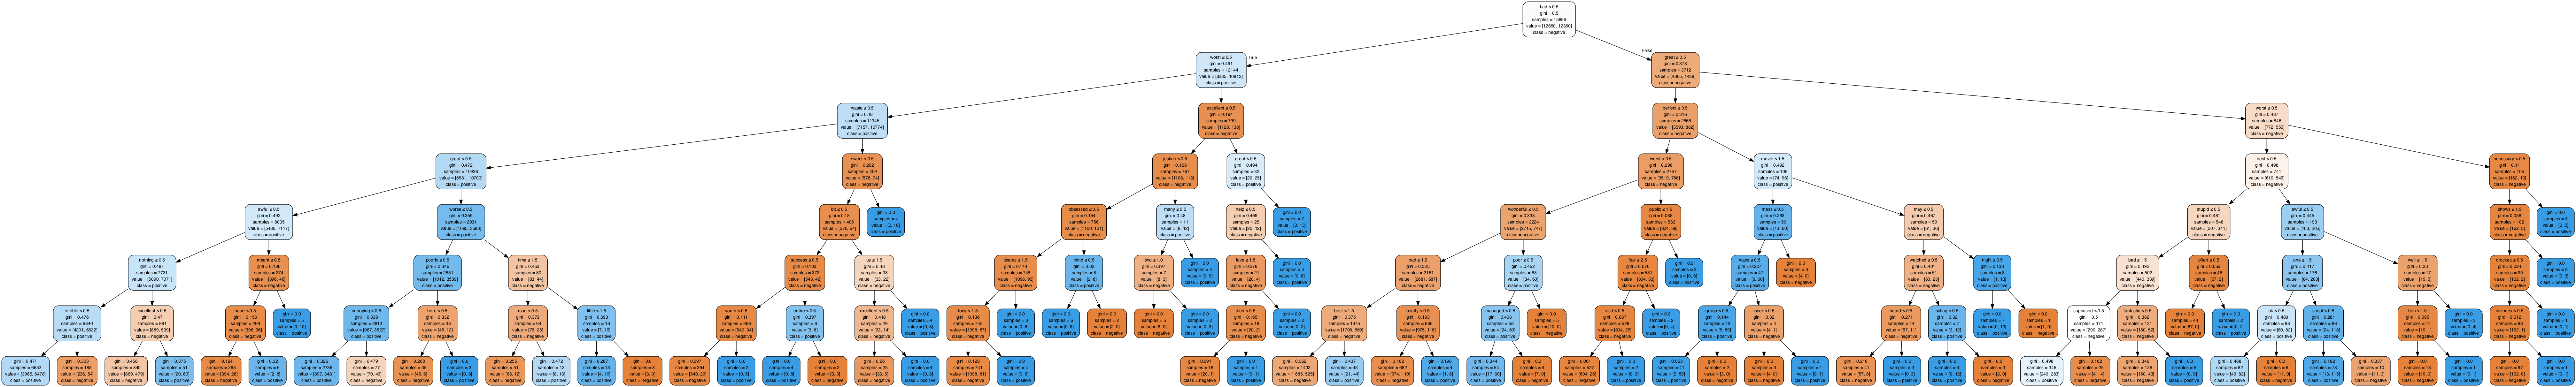

In [37]:
dot_data = StringIO()
export_graphviz(bestModel, out_file=dot_data, feature_names=features, 
               class_names=['negative','positive'], filled=True, rounded=True, 
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [42]:
graph.write_png('../reports/wordcloud/decisionTree.png')

True

**The decision tree above is one of the sections of random forest which shows the branching to positive and negative sentiments based on the occurrence of words.**

## Logistic regression for positive and negative words

In [43]:
params = {
    'C':[0.07,0.09,0.1,0.2,0.3,0.5,1]
}

logisticModel = LogisticRegression(random_state=6,verbose=0,n_jobs=-1)
gridSearch = GridSearchCV(logisticModel, params,verbose=3,n_jobs=-1)
gridSearch.fit(trainFeatures, trainDf.label)
print(gridSearch.best_estimator_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   26.5s finished
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.07, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=6,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [41]:
posEg = {}
negEg = {}
bestModel = gridSearch.best_estimator_
indicesForPosEg = np.argsort(-1*bestModel.coef_)[:,0:100][0]
for i in indicesForPosEg[0:100]:
    posEg[features[i]] = bestModel.coef_[0,i]
indicesForNegEg = np.argsort(bestModel.coef_)[:,0:100][0]
for i  in indicesForNegEg[0:100]:
    negEg[features[i]] = -1*bestModel.coef_[0,i]

the accuracy of training set is :0.9638
the accuracy of testing set is :0.87888
[[11011  1489]
 [ 1539 10961]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



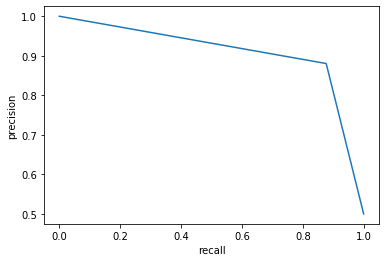

In [29]:
bestModel = gridSearch.best_estimator_
dump(bestModel, '../models/logisticRegression.joblib')

loadedModel = load('../models/logisticRegression.joblib')

trainPredictLR = loadedModel.predict(trainFeatures)
testPredictLR = loadedModel.predict(testFeatures)

accuracyLRtrain = accuracy_score(trainDf.label, trainPredictLR)
accuracyLRtest = accuracy_score(testDf.label, testPredictLR)
print("the accuracy of training set is :{}".format(accuracyLRtrain))
print("the accuracy of testing set is :{}".format(accuracyLRtest))
print(confusion_matrix(testDf.label,testPredictLR))
print(classification_report(testDf.label,testPredictLR))
precision, recall, threshold = precision_recall_curve(testDf.label,testPredictLR)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

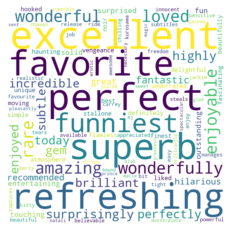

In [45]:
wordcloudLogRegPos = wordCloudFromFrequency(posEg)
plotWordCloud(wordcloudLogRegPos)

In [46]:
wordcloudLogRegPos.to_file('../reports/wordcloud/wordcloudLogRegressionPos.png')

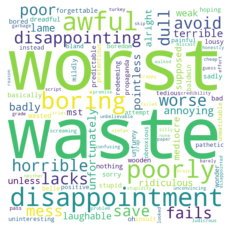

In [47]:
wordcloudLogRegNeg = wordCloudFromFrequency(negEg)
plotWordCloud(wordcloudLogRegNeg)

In [49]:
wordcloudLogRegNeg.to_file('../reports/wordcloud/wordcloudLogRegressionNeg.png')

**The logistic regression showed the higher accurracy for classification and the wordclouds represent the important postive as well as negative words used for classification.**